In [220]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 1. upload data sets, and convert to pandas data frames
country_stats_data = pd.read_csv("country_happiness_report.csv")
all_int_football_results = pd.read_csv("all_int_football_results.csv")
historic_wc_top_three = pd.read_csv("historical_world_cup_top_three.csv")
fifa_players_data = pd.read_csv("fifa_players.csv")

# 2. clean data.
# replace missing values by mean of set, given attribute and data set.
# replace missing values by mode of set, given attribute and data set.
# given attrs to keep in the set, trim set.
# aggregate to provide clarity when relevant
# organize existing data into meaningful data frames.


In [221]:
# extra dataset not yet needed
# TODO: delete this if we won't use it.
# historic_wc_games_data = pd.read_csv("historical_world_cup_final_bracket_games.csv")

In [222]:
# fifa_players_data
# data cleaning
# minimize attributes used.
# fill national team based on nationality if value is null.
# fill numeric missing values with mean.
# fill categorical missing values with mode.
# normalize attribute values that are numeric for consistency in correlation
# sort players by overall rating.
top_player_attrs = [
    'full_name',
    'nationality',
    'overall_rating',
    'positions',
    'value_euro',
    'wage_euro',
    'preferred_foot',
    'international_reputation(1-5)',
    'body_type',
    'national_team', # use nationality if na
]
top_player_fill_mean_attrs = [
    'overall_rating',
    'value_euro',
    'wage_euro',
    'international_reputation(1-5)',
]
top_player_fill_mode_attrs = [
    'preferred_foot',
    'body_type',
]

selected_attrs_cols = [col for col in fifa_players_data.columns if col in top_player_attrs]
fifa_top_players_data = fifa_players_data[selected_attrs_cols]
fifa_top_players_data['national_team'] = fifa_players_data.national_team.fillna(fifa_top_players_data['nationality'])
# data cleaning - fill by means and modes based on attr set.
fifa_top_players_data[top_player_fill_mean_attrs] = fifa_top_players_data[top_player_fill_mean_attrs].transform(lambda x: x.fillna(x.mean()))
fifa_top_players_data[top_player_fill_mode_attrs] = fifa_top_players_data[top_player_fill_mode_attrs].transform(lambda x: x.fillna(x.mode()))

# normalize numeric attr values
top_player_subset_attrs = [
    'full_name',
    'nationality',
    'overall_rating',
    'crossing',
    'finishing',
    'heading_accuracy',
    'short_passing',
    'volleys',
    'dribbling',
    'curve',
    'freekick_accuracy',
    'long_passing',
    'ball_control',
    'acceleration',
    'sprint_speed',
    'agility',
    'reactions',
    'shot_power',
    'jumping',
    'stamina',
    'strength',
    'long_shots'
]
# create a subset data table for player skills
top_player_skill_attrs = [attr for attr in top_player_subset_attrs if attr is not 'full_name' and attr is not 'nationality' ]
selected_attrs_cols = [col for col in fifa_players_data.columns if col in top_player_subset_attrs]

fifa_top_players_skills_data = fifa_players_data[selected_attrs_cols]
# normalize
fifa_top_players_skills_data[top_player_skill_attrs] = fifa_top_players_skills_data[top_player_skill_attrs].apply(lambda x:(x-x.min()) / (x.max()-x.min()))
# fifa_top_players_data
fifa_top_players_skills_data.sort_values(by=['overall_rating'], inplace=True, ascending=False)
# fifa_top_players_skills_data.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [223]:
# historic_wc_top_three
# organize historical world cup data by country
# aggregate records in terms of number of times finishing in a given place in final four
# fill na with 0
# add column for sum of total QF appearances
# rename some columns so there is clearly First, Second, Third, Fourth 

finishes = ['Winner', 'Runners-Up', 'Third', 'Fourth']

wc_hist_perf_summary = pd.DataFrame(data=historic_wc_top_three['Country'])
for finish in finishes:
    temp_sum = pd.DataFrame()
    temp_sum[finish] = historic_wc_top_three[finish].value_counts()
    temp_sum = temp_sum.rename_axis('Country')
    temp_sum['Country'] = temp_sum.index
    wc_hist_perf_summary = pd.merge(wc_hist_perf_summary,temp_sum, how='left', on="Country", left_index=False, right_index=False)

wc_hist_perf_summary[finishes] = wc_hist_perf_summary[finishes].transform(lambda x: x.fillna(0)).transform(lambda x: x.astype(int))
wc_hist_perf_summary['Sum QF Appearances'] = wc_hist_perf_summary.sum(axis=1)
wc_hist_perf_summary = wc_hist_perf_summary.rename(columns={'Runners-Up': 'Second', 'Winner': 'First'})
# wc_hist_perf_summary

In [224]:
# historic_wc_top_three
# aggregate top finishes for each country using aggregated data on qf finishes (only including qf finishes)
fifa_wc_results = all_int_football_results.loc[all_int_football_results['tournament'] == 'FIFA World Cup']

def find_top_finish_in_qf(row):
    # print(row['Country'])
    country = row['Country']
    finishes = wc_hist_perf_summary.loc[wc_hist_perf_summary['Country'] == country]
    top_finish = 0
    first = (finishes.First).all()
    second = (finishes.Second).all()
    third = (finishes.Third).all()
    fourth = (finishes.Fourth).all()
    if (first):
        top_finish = 1
    elif (second):
        top_finish = 2
    elif (third):
        top_finish = 3
    elif (fourth):
        top_finish = 4
    return top_finish

top_finishes_in_qf = pd.DataFrame(data=wc_hist_perf_summary['Country'])
top_finishes_in_qf['top finish'] = top_finishes_in_qf.apply(lambda x: find_top_finish_in_qf(x), axis=1)
# top_finishes_in_qf

In [225]:
# minimize, clean, and aggregate country happiness data
# minimize number of attributes in set
# select a number of years for each country using broundaries.
# TODO: add a row for a year not present based on mean.
# find the mean for each country
# TODO: remove years column
# for data with NAN values, data was NaN for all values in country.  Update with mean from column.
selected_attrs_country = [
    'country',
    'year', 
    'Life Ladder',
    'Log GDP per capita',
    'Social support',
    'Healthy life expectancy at birth',
    'Freedom to make life choices',
    'Generosity',
    'Positive affect',
    'Negative affect',
    'Confidence in national government', 
    'Democratic Quality',
    'Most people can be trusted, Gallup',
]

attrs_for_cleaning_nans = [
    'Life Ladder',
    'Log GDP per capita',
    'Social support',
    'Healthy life expectancy at birth',
    'Freedom to make life choices',
    'Generosity',
    'Positive affect',
    'Negative affect',
    'Confidence in national government', 
    'Democratic Quality',
    'Most people can be trusted, Gallup',
]

# minimize data set
selected_attrs_cols = [col for col in country_stats_data.columns if col in selected_attrs_country]
country_data = country_stats_data[selected_attrs_cols]

# set date boundaries 
start_remove = 2014
end_remove = 2016
# group data by country and use mean for group override NAN with mean.
for attr in attrs_for_cleaning_nans:
    country_data[attr] = country_data.groupby('country', as_index=False)[attr].transform(lambda x: x.fillna(x.mean()))

# filter for years in boundaries
country_data = country_data.loc[(country_data.year >= start_remove) & (country_data.year <= end_remove)]
# get mean for country over years
country_data = country_data.groupby('country', as_index=False)[selected_attrs_cols].mean()
# remaining NaNs are because data was NaN for all values in country.  replace these with mean from column.
country_data = country_data.fillna(country_data.mean())
# country_data


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [226]:
# fifa_wc_results
# minimize dataset to only FIFA World Cup matches from 2018. 
# determine winners of matches
# aggregate wins by country to total be total counts
# sort
fifa_wc_results = all_int_football_results.loc[all_int_football_results['tournament'] == 'FIFA World Cup']
fifa_wc_results_2018 = fifa_wc_results.loc[all_int_football_results['date'].str.contains('2018')]

def find_winner(row):
    if row.home_score > row.away_score:
        return row.home_team
    elif row.home_score < row.away_score:
        return row.away_team
    else:
        return 'tie'

# TODO: compile this into dataset in csv form https://www.wikiwand.com/en/2018_FIFA_World_Cup_statistics#/Overall_results
# add new column from function given row data
fifa_wc_results_2018['winner'] = fifa_wc_results_2018.apply(lambda row: find_winner(row), axis=1)
fifa_wc_results_2018_winners = fifa_wc_results_2018.groupby(['winner']).winner.agg('count').to_frame('num_wins').reset_index()
#fifa_wc_results_2018
fifa_wc_results_2018_winners = pd.DataFrame(fifa_wc_results_2018_winners)
fifa_wc_results_2018_winners.sort_values(by=['num_wins'], inplace=True, ascending=False)
# fifa_wc_results_2018_winners.head()


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [227]:
# fifa_wc_results
# minimize dataset to only FIFA World Cup matches from 2018. 
# determine winners of matches
# aggregate wins by country to total be total counts
# sort
fifa_wc_results = all_int_football_results.loc[all_int_football_results['tournament'] == 'FIFA World Cup']
fifa_wc_results_all_time = fifa_wc_results

def find_winner(row):
    if row.home_score > row.away_score:
        return row.home_team
    elif row.home_score < row.away_score:
        return row.away_team
    else:
        return 'tie'

# TODO: compile this into dataset in csv form https://www.wikiwand.com/en/2018_FIFA_World_Cup_statistics#/Overall_results
# add new column from function given row data
fifa_wc_results_all_time['winner'] = fifa_wc_results_all_time.apply(lambda row: find_winner(row), axis=1)
fifa_wc_results_all_time_winners = fifa_wc_results_all_time.groupby(['winner']).winner.agg('count').to_frame('num_wins').reset_index()
#fifa_wc_results_2018
fifa_wc_results_all_time_winners = pd.DataFrame(fifa_wc_results_all_time_winners)
fifa_wc_results_all_time_winners.sort_values(by=['num_wins'], inplace=True, ascending=False)
# fifa_wc_results_all_time_winners

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [228]:
# join simple soccer 2018 wc wins and country data set
merged_2018_wc_wins_and_happiness_by_country = pd.merge(left=fifa_wc_results_2018_winners,right=country_data, left_on='winner', right_on='country')
merged_2018_wc_wins_and_happiness_by_country = merged_2018_wc_wins_and_happiness_by_country.drop(['winner'], axis=1)


In [229]:
# datasets
# top players skills, in order of rank.
fifa_top_players_skills_data.head()
# world cup performance summary for each country, showing number of times they finished in the top four and sum of 
# all qf appearances, historically.
wc_hist_perf_summary.head()
# top finish for a country who has played in a WC quarter final match.
top_finishes_in_qf.head()
# country data happiness
country_data.head()
# 2018 wc number of wins for top countries (excluding 2018)
fifa_wc_results_2018_winners.head()
# total number of matches won by each countries in all world cups, historically (excluding 2018)
# fifa_wc_results_all_time_winners.head()

,winner,num_wins
26,tie,13
1,Belgium,6
7,France,6
4,Croatia,4
25,Uruguay,4


In [230]:
# merged test:
# merged_2018_wc_wins_and_happiness_by_country.head()

In [231]:
# merge num_wins with happiness data for each row (keep rows joined on country), correlation for attr.
fifa_wc_winners_and_country_happiness = pd.merge(left=fifa_wc_results_all_time_winners,right=country_data, left_on='winner', right_on='country')
fifa_wc_winners_and_country_happiness = fifa_wc_winners_and_country_happiness.drop(['year', 'winner'], axis=1)
#fifa_wc_winners_and_country_happiness.head()

In [232]:
fifa_top_players_skills_and_country_happiness = pd.merge(left=fifa_top_players_skills_data,right=country_data, left_on='nationality', right_on='country')
# fifa_top_players_skills_and_country_happiness.head()

In [233]:
# merge num_wins with happiness data for each row (keep rows joined on country), correlation for attr.

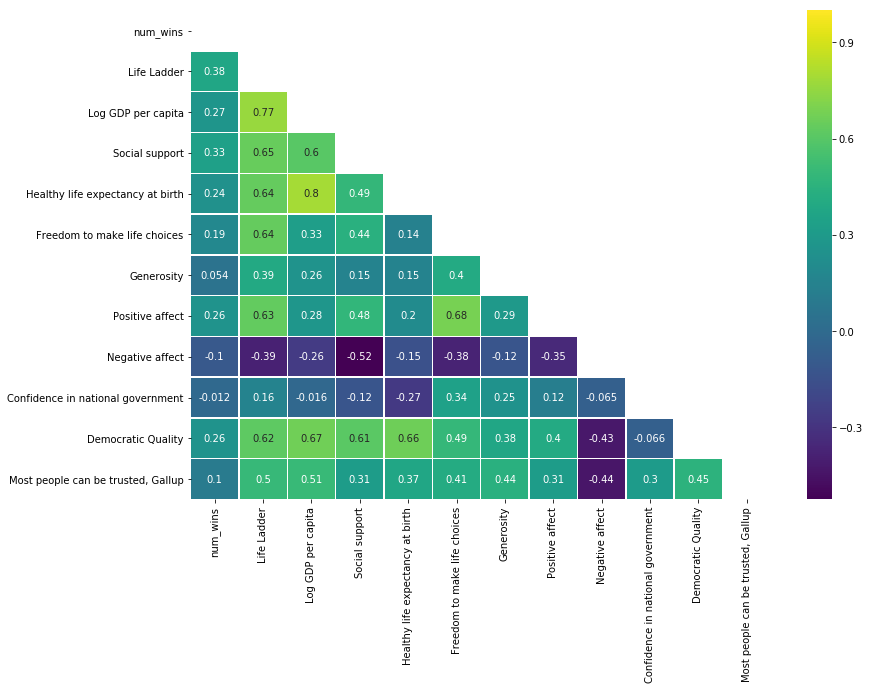

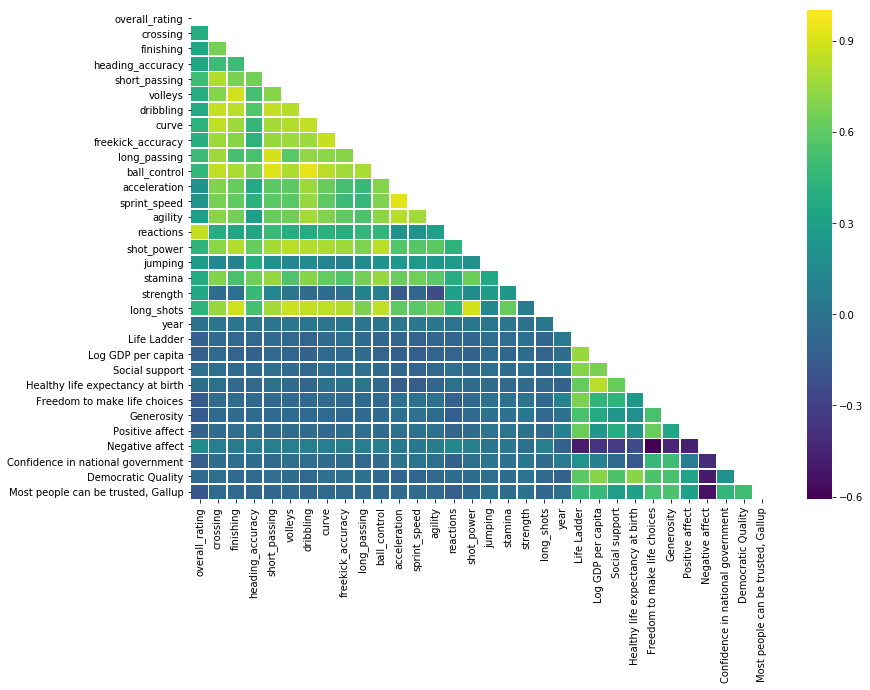

In [234]:
# If you have a lot of variables, you can use the pandas.DataFrame method corr() 
# to calculate a correlation matrix that shows the correlation coefficient for each pair of variables.
# correlated_fifa_winners_and_national_happiness
def create_correlation_heatmap(dataset, show_corr_nums):
    c_f_w_a_n_p = dataset.corr()
    mask = np.zeros_like(c_f_w_a_n_p, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(13, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(c_f_w_a_n_p, vmax=1., annot=show_corr_nums, mask=mask, linewidths=.5, cmap="viridis")
    
create_correlation_heatmap(fifa_wc_winners_and_country_happiness, True)
create_correlation_heatmap(fifa_top_players_skills_and_country_happiness, False)


In [260]:
import scipy.stats
my_panda = pd.DataFrame()

for attr in attrs_for_cleaning_nans:
    x = fifa_wc_winners_and_country_happiness.num_wins
    y = fifa_wc_winners_and_country_happiness[attr]
    z = scipy.stats.pearsonr(x.values,y.values)[0]
    
    a = y.corr(x)
    my_panda.at[attr, 'Pearsons'] = z
    my_panda.at[attr, 'Corr'] = a
my_panda.sort_values(by=['Corr'], inplace=True, ascending=False)
my_panda

,Pearsons,Corr
Life Ladder,0.379623,0.379623
Social support,0.333573,0.333573
Log GDP per capita,0.272708,0.272708
Democratic Quality,0.260263,0.260263
Positive affect,0.257264,0.257264
Healthy life expectancy at birth,0.243334,0.243334
Freedom to make life choices,0.188992,0.188992
"Most people can be trusted, Gallup",0.104028,0.104028
Generosity,0.053956,0.053956
Confidence in national government,-0.012465,-0.012465


In [ ]:
# try
# corr = data.corr()
# fig = plt.figure()
# ax = fig.add_subplot(111)
# cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
# fig.colorbar(cax)
# ticks = np.arange(0,len(data.columns),1)
# ax.set_xticks(ticks)
# plt.xticks(rotation=90)
# ax.set_yticks(ticks)
# ax.set_xticklabels(data.columns)
# ax.set_yticklabels(data.columns)
# plt.show()

In [ ]:
# correlation matrix
# corr = data.corr()
# ax = sns.heatmap(
#     corr, 
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# );

In [ ]:
# find most correlated with wins. - also integrate in some other win data.
# do the same with player skillset. -- join on nationality they play for.  determine correlation on country win, based on player skillset.

In [ ]:
# apriori - find sets 

In [ ]:
# multivariate scatterplot matrix
# pd.tools.plotting.scatter_matrix(data.loc[:, "V2":"V6"], diagonal="kde")
# plt.tight_layout()
# plt.show()

In [ ]:
# profile plot - variations in each variable
# ax = data[["V2","V3","V4","V5","V6"]].plot()
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));